# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [217]:
import re
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import pickle
import operator
import skmisc
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from math import sqrt
from IPython.display import display
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *
from treeinterpreter import treeinterpreter as ti
import waterfall_chart

In [4]:
DATA_DIR = "data/"
DATA_RAW = DATA_DIR+"raw/"
DATA_TEMP = DATA_DIR+"temp/"
MODELS_DIR = "models/"
os.listdir(DATA_RAW)

['.DS_Store',
 'test.csv',
 'data_description.txt',
 'train.csv',
 'sample_submission.csv']

# Load data

In [5]:
%time df_train_raw = pd.read_csv(f"{DATA_RAW}train.csv")
%time df_test_raw = pd.read_csv(f"{DATA_RAW}test.csv")

CPU times: user 25.4 ms, sys: 5.93 ms, total: 31.3 ms
Wall time: 38.2 ms
CPU times: user 21.5 ms, sys: 2.56 ms, total: 24.1 ms
Wall time: 23.2 ms


In [9]:
df_train_raw.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
def missing_values_stats(df, keep_zeros=False):
    """
        The function return stats on the missing values in the dataframe.
        
        Inputs:
            df: dataframe to analyze
            keep_zeros: boolean to specify if the columns with zeros missing values are kept in the stats.
        
        Outputs:
            res: A data frame containing for each columns of df the total of missing values and the percetage.
        
    """
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [16]:
miss_train = missing_values_stats(df_train_raw)
miss_test = missing_values_stats(df_test_raw)

In [19]:
miss_train.index.values == miss_test.index.values

False

In [21]:
print("Missing train: ", miss_train.shape)
print("Missing test: ", miss_test.shape)

Missing train:  (19, 2)
Missing test:  (33, 2)


In [35]:
miss = missing_values_stats(df_train_raw, True).join(missing_values_stats(df_test_raw, True), lsuffix="_train", rsuffix="_test")

In [39]:
miss[(miss.Total_train == 0) & (miss.Total_test > 0)]

,Total_train,Percentage_train,Total_test,Percentage_test
Utilities,0,0.0,2.0,0.14
Exterior2nd,0,0.0,1.0,0.07
Exterior1st,0,0.0,1.0,0.07
BsmtFinSF1,0,0.0,1.0,0.07
MSZoning,0,0.0,4.0,0.27
BsmtFinSF2,0,0.0,1.0,0.07
GarageCars,0,0.0,1.0,0.07
GarageArea,0,0.0,1.0,0.07
BsmtUnfSF,0,0.0,1.0,0.07
SaleType,0,0.0,1.0,0.07


In [40]:
df_train_raw.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [41]:
categorical_features = [col_name for col_name, col in df_train_raw.items() if pd.api.types.is_object_dtype(col)]
numerical_features = [col_name for col_name, col in df_train_raw.items() if not pd.api.types.is_object_dtype(col)]

In [55]:
pd.DataFrame([len(df_train_raw[feat].unique()) for feat in numerical_features], index=numerical_features, columns=["Cardinality"]).sort_values("Cardinality")

,Cardinality
BsmtHalfBath,3
HalfBath,3
FullBath,4
BsmtFullBath,4
Fireplaces,4
KitchenAbvGr,4
GarageCars,5
YrSold,5
BedroomAbvGr,8
PoolArea,8


In [60]:
df_train_raw["OverallQual"].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [62]:
cat_feats = categorical_features + ["BsmtHalfBath", "HalfBath", "FullBath", "BsmtFullBath", 
                        "KitchenAbvGr", "GarageCars", "BedroomAbvGr", "OverallCond", "OverallQual",
                       "TotRmsAbvGrd", "MSSubClass"]

In [108]:
df_train_cat = df_train_raw[cat_feats]
df_train_num = df_train_raw[[col_name for col_name in df_train_raw.columns if not col_name in df_train_cat.columns]]

In [109]:
df_train_num.drop("Id", axis=1, inplace=True)

In [110]:
missing_values_stats(df_train_cat)

,Total,Percentage
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
GarageCond,81,5.55
GarageType,81,5.55
GarageQual,81,5.55
GarageFinish,81,5.55
BsmtFinType2,38,2.60


In [111]:
df_train_cat["PoolQC"].fillna("No Pool", inplace=True)

In [112]:
df_train_cat["MiscFeature"].fillna("No Feature", inplace=True)

In [113]:
df_train_cat["Alley"].fillna("No Alley", inplace=True)

In [114]:
df_train_cat["Fence"].fillna("No Fence", inplace=True)

In [115]:
df_train_cat["FireplaceQu"].fillna("No Fireplace", inplace=True)

In [116]:
df_train_cat["GarageCond"].fillna("No Garage", inplace=True)

In [117]:
df_train_cat["GarageType"].fillna("No Garage", inplace=True)

In [118]:
df_train_cat["GarageQual"].fillna("No Garage", inplace=True)

In [119]:
df_train_cat["GarageFinish"].fillna("No Garage", inplace=True)

In [120]:
df_train_cat["BsmtFinType2"].fillna("No Basement", inplace=True)

In [121]:
df_train_cat["BsmtExposure"].fillna("No Basement", inplace=True)

In [122]:
df_train_cat["BsmtFinType1"].fillna("No Basement", inplace=True)

In [123]:
df_train_cat["BsmtCond"].fillna("No Basement", inplace=True)

In [124]:
df_train_cat["BsmtQual"].fillna("No Basement", inplace=True)

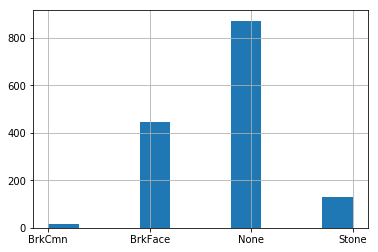

In [142]:
df_train_cat["MasVnrType"].hist()

In [126]:
df_train_cat["MasVnrType"].fillna("None", inplace=True)

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

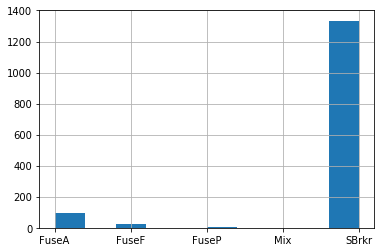

In [127]:
df_train_cat["Electrical"].hist()
df_train_cat["Electrical"].unique()

In [128]:
df_train_cat["Electrical"].fillna("SBrkr", inplace=True)

In [129]:
missing_values_stats(df_train_cat)

,Total,Percentage


In [145]:
miss_num = missing_values_stats(df_train_num)
miss_num

,Total,Percentage
LotFrontage,259,17.74
GarageYrBlt,81,5.55
MasVnrArea,8,0.55


69.0

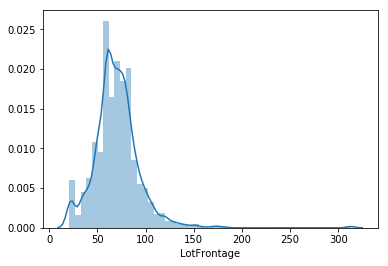

In [140]:
#df_train_num["LotFrontage"].dropna().hist()
sns.distplot(df_train_num["LotFrontage"].dropna())
df_train_num["LotFrontage"].dropna().median()

1980.0

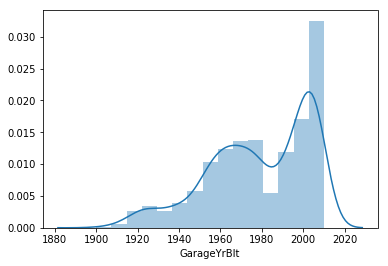

In [143]:
sns.distplot(df_train_num["GarageYrBlt"].dropna())
df_train_num["GarageYrBlt"].dropna().median()

0.0

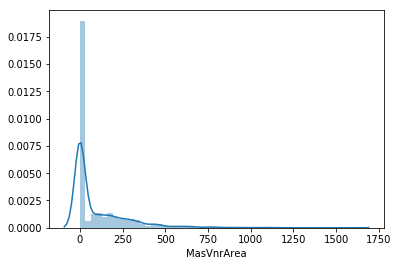

In [144]:
sns.distplot(df_train_num["MasVnrArea"].dropna())
df_train_num["MasVnrArea"].dropna().median()

In [149]:
for col_name in miss_num.index.values:
    print(col_name)
    df_train_num[col_name+"_na"] = df_train_num[col_name].isnull()
    df_train_num[col_name] = df_train_num[col_name].fillna(df_train_num[col_name].dropna().median())

LotFrontage
GarageYrBlt
MasVnrArea


In [150]:
missing_values_stats(df_train_num)

,Total,Percentage


In [165]:
# Convert to pandas cat
for col_name in df_train_cat:
    df_train_cat[col_name] = df_train_cat[col_name].astype("category")

In [167]:
df_train = df_train_cat.join(df_train_num)

In [168]:
df_train.dtypes

MSZoning          category
Street            category
Alley             category
LotShape          category
LandContour       category
Utilities         category
LotConfig         category
LandSlope         category
Neighborhood      category
Condition1        category
Condition2        category
BldgType          category
HouseStyle        category
RoofStyle         category
RoofMatl          category
Exterior1st       category
Exterior2nd       category
MasVnrType        category
ExterQual         category
ExterCond         category
Foundation        category
BsmtQual          category
BsmtCond          category
BsmtExposure      category
BsmtFinType1      category
BsmtFinType2      category
Heating           category
HeatingQC         category
CentralAir        category
Electrical        category
                    ...   
MSSubClass        category
LotFrontage        float64
LotArea              int64
YearBuilt            int64
YearRemodAdd         int64
MasVnrArea         float64
B

In [172]:
df_train["SalePrice"] = df_train_raw["SalePrice"]

In [175]:
df_train["SalePrice"] = np.log(df_train_raw["SalePrice"])

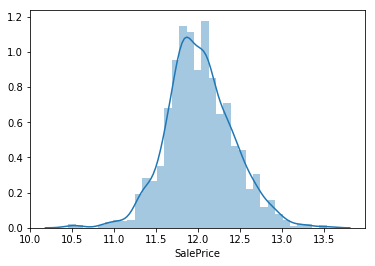

In [176]:
sns.distplot(df_train["SalePrice"])

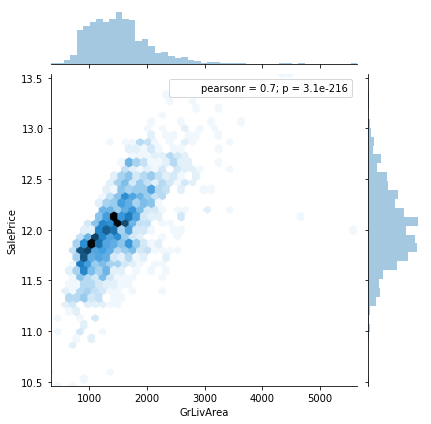

In [177]:
sns.jointplot(df_train["GrLivArea"], df_train["SalePrice"], kind="hex")

In [178]:
df_train.to_feather(f"{DATA_TEMP}df_train.frt")
with open(f"{DATA_TEMP}cat_feats", "wb") as handle:
    pickle.dump(list(df_train_cat.columns), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f"{DATA_TEMP}num_feats", "wb") as handle:
    pickle.dump(list(df_train_num.columns), handle, protocol=pickle.HIGHEST_PROTOCOL)

# First Model

In [423]:
df_train = pd.read_feather(f"{DATA_TEMP}df_train.frt")

In [424]:
# Create dummies for category features
df_train_dummies = df_train.copy()
for col_name, col in df_train_dummies.items():
    if pd.api.types.is_categorical_dtype(col):
        df_train_dummies = df_train_dummies.join(pd.get_dummies(col, prefix=col_name))

In [376]:
# Save mapper from code to category and vice-versa for each categorical features
category_mapper = {col_name: {code: idx for code, idx in enumerate(col.cat.categories)} for col_name, col in df_train.items() if pd.api.types.is_categorical_dtype(col)}
category_inv_mapper = {col_name: {idx: code for code, idx in enumerate(col.cat.categories)} for col_name, col in df_train.items() if pd.api.types.is_categorical_dtype(col)}

In [437]:
for col_name, col in df_train.items():
    if pd.api.types.is_categorical_dtype(col):
        df_train[col_name] = col.cat.codes

In [378]:
cat_feats = [col_name for col_name in df_train.columns if pd.api.types.is_categorical_dtype(df_train[col_name])]
cat_feats

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'BsmtHalfBath',
 'HalfBath',
 'FullBath',
 'BsmtFullBath',
 'KitchenAbvGr',
 'GarageCars',
 'BedroomAbvGr',
 'OverallCond',
 'OverallQual',
 'TotRmsAbvGrd',
 'MSSubClass']

In [379]:
keep_feats = [col_name for col_name in df_train.columns if not col_name in cat_feats+["SalePrice"]]

In [380]:
y, X = df_train["SalePrice"], df_train[keep_feats]

In [382]:
random_forest = RandomForestRegressor(n_estimators=50, max_features=.5, n_jobs=-1, oob_score=True)

In [383]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

In [384]:
%time scores = cross_validate(random_forest, X, y, cv=5, scoring=make_scorer(rmse))

CPU times: user 6.37 s, sys: 146 ms, total: 6.52 s
Wall time: 2.74 s


In [385]:
scores

{'fit_time': array([ 0.3035481 ,  0.31172204,  0.30489492,  0.30136395,  0.32835889]),
 'score_time': array([ 0.11215973,  0.1116848 ,  0.10787511,  0.11165214,  0.1147089 ]),
 'test_score': array([ 0.13055101,  0.1624049 ,  0.14960436,  0.13303287,  0.14721403]),
 'train_score': array([ 0.05651965,  0.05450432,  0.05416353,  0.05468638,  0.05753695])}

In [386]:
print("RMSE: %0.5f (+/- %0.5f)" % (scores["test_score"].mean(), scores["test_score"].std() * 2))

RMSE: 0.14456 (+/- 0.02332)


In [387]:
random_forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

# Features importance

In [388]:
def get_features_importance(model, df):
    return pd.DataFrame({"cols": df.columns.values, "imp": model.feature_importances_}).sort_values("imp", ascending=False)

In [389]:
feat_importance = get_features_importance(random_forest, X)

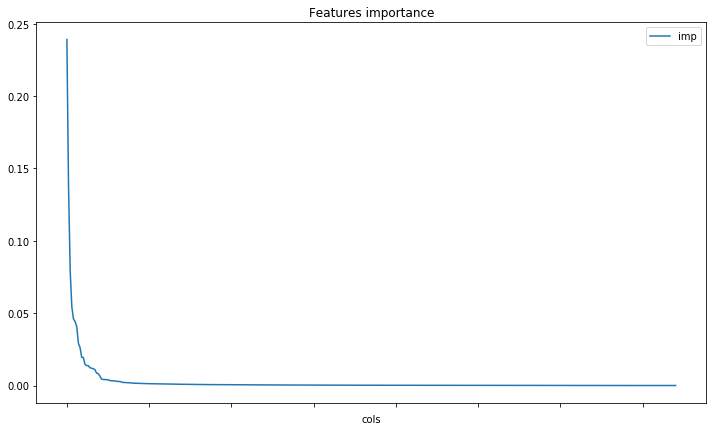

In [390]:
feat_importance.plot("cols", "imp", title="Features importance", figsize=(12,7))

In [391]:
def plot_feat_importance(fi):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7))

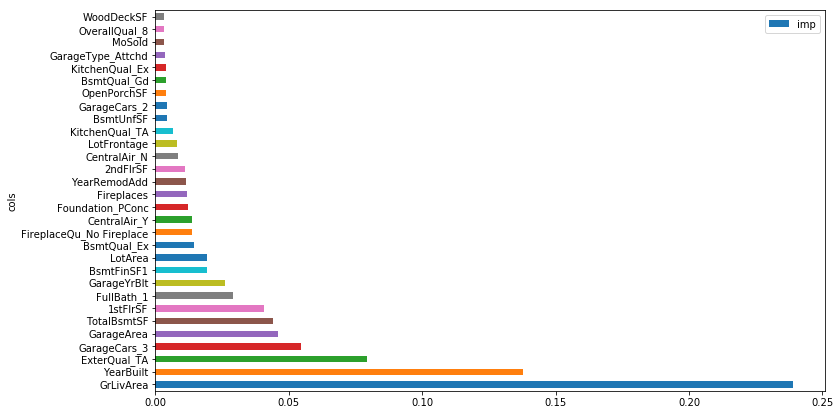

In [392]:
plot_feat_importance(feat_importance[:30])

In [393]:
# No need to plot all the dataset, we are gonna use a random sample of it
def get_sample(df, n):
    """
    Return a sample of the data frame of size n.
    
    Inputs
    ===
    - df: the input data frame.
    - n: the size of the sample.
    
    Outputs
    ===
    - a data frame with a random sample of size n of the input data frame.
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [394]:
def plot_pdp(model, feat, x_train_aux, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model, x_train_aux, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

In [329]:
df_aux = df_train.copy()
df_aux["SalePrice"] = y
df_sample = get_sample(df_aux, 1000)

In [409]:
regex = re.compile("PoolQC_.*")
l = list(filter(regex.match, df_train.columns.values))
l

['PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_No Pool']

In [410]:
pdp_PoolQC_rf = pdp.pdp_isolate(random_forest, df_train[keep_feats], l)

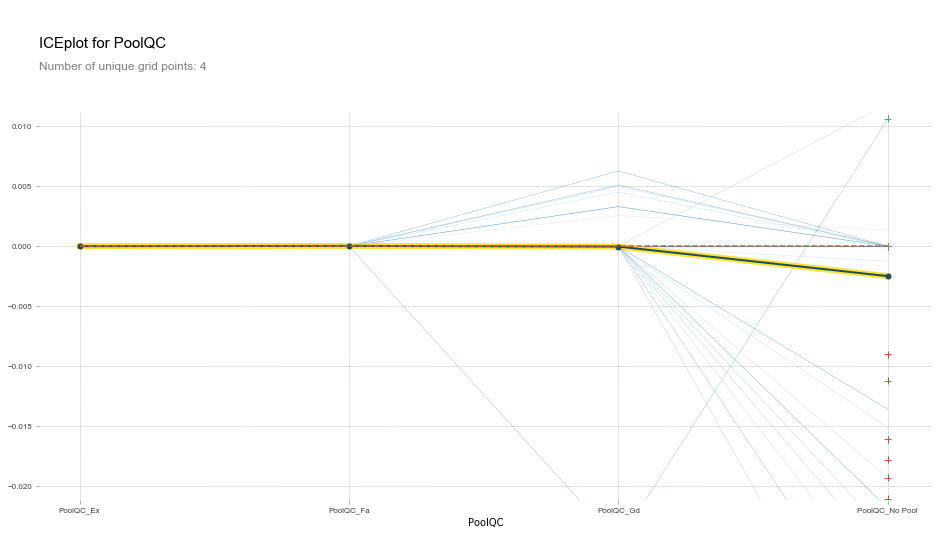

In [411]:
pdp.pdp_plot(pdp_PoolQC_rf, "PoolQC", plot_org_pts=True, plot_lines=True, frac_to_plot=100)

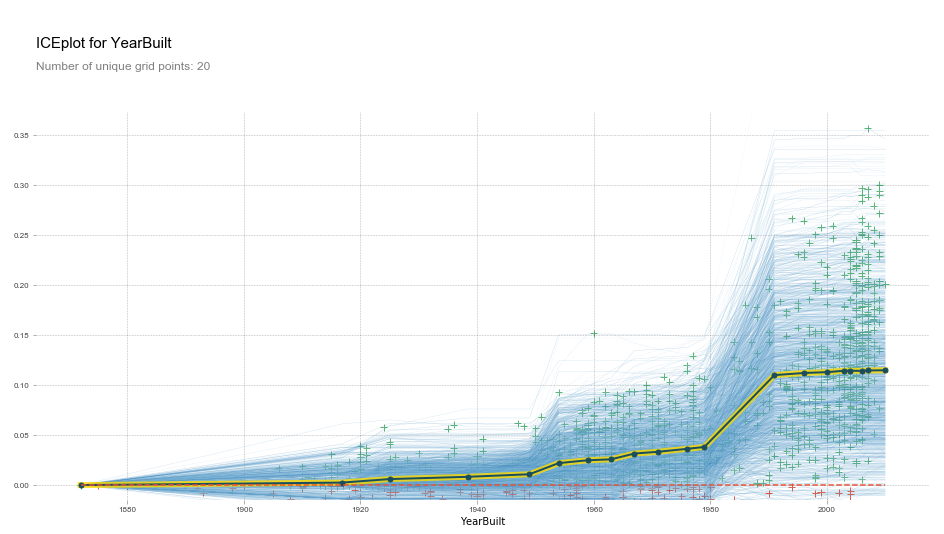

In [417]:
pdp_area_rf = pdp.pdp_isolate(random_forest, df_train[keep_feats], 'YearBuilt', num_grid_points=20)
pdp.pdp_plot(pdp_area_rf, 'YearBuilt', plot_org_pts=True, plot_lines=True, frac_to_plot=1)

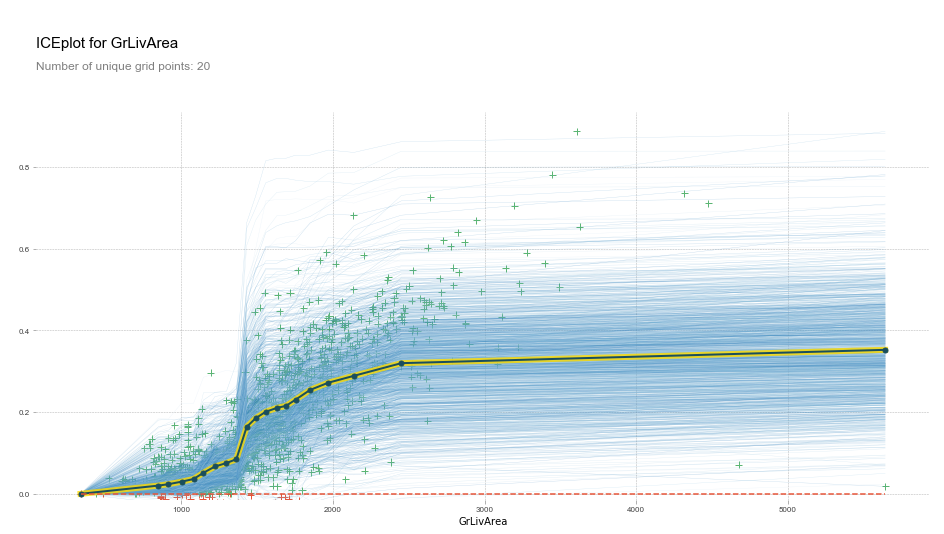

In [418]:
pdp_area_rf = pdp.pdp_isolate(random_forest, df_train[keep_feats], 'GrLivArea', num_grid_points=20)
pdp.pdp_plot(pdp_area_rf, 'GrLivArea', plot_org_pts=True, plot_lines=True, frac_to_plot=1)

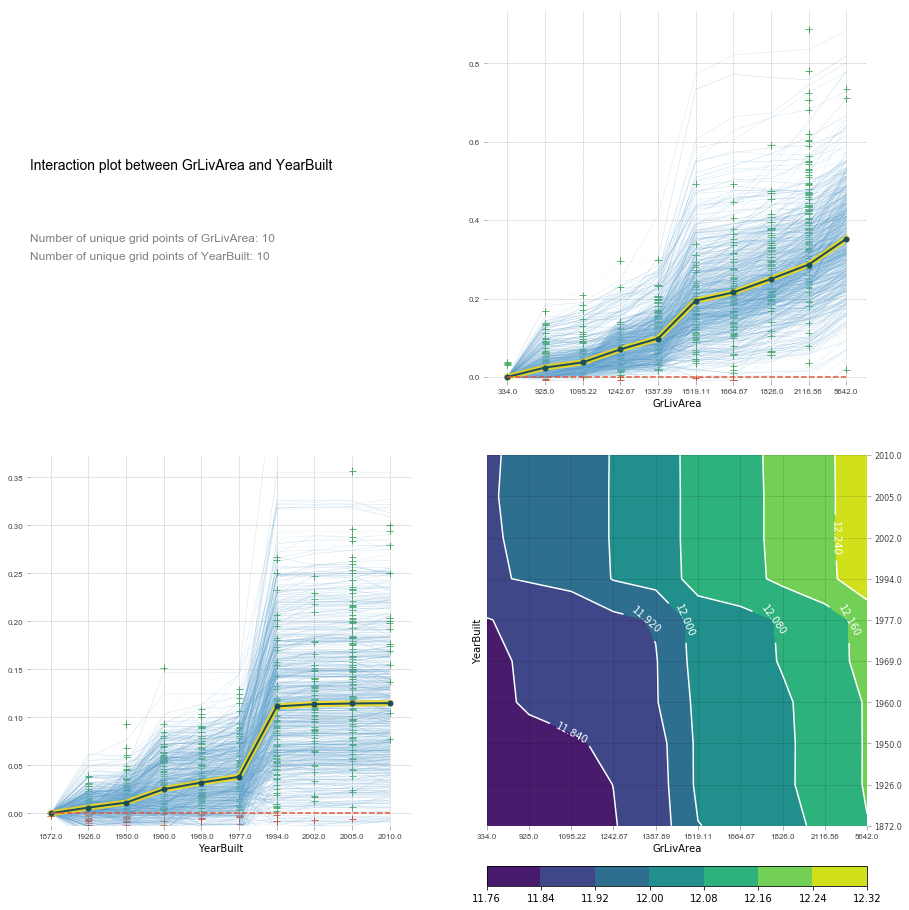

In [419]:
inter_rf = pdp.pdp_interact(random_forest, df_train[keep_feats], ['GrLivArea', 'YearBuilt'], num_grid_points=[10, 10])
pdp.pdp_interact_plot(inter_rf, ['GrLivArea', 'YearBuilt'], center=True, plot_org_pts=True, plot_lines=True, frac_to_plot=0.5, x_quantile=True)

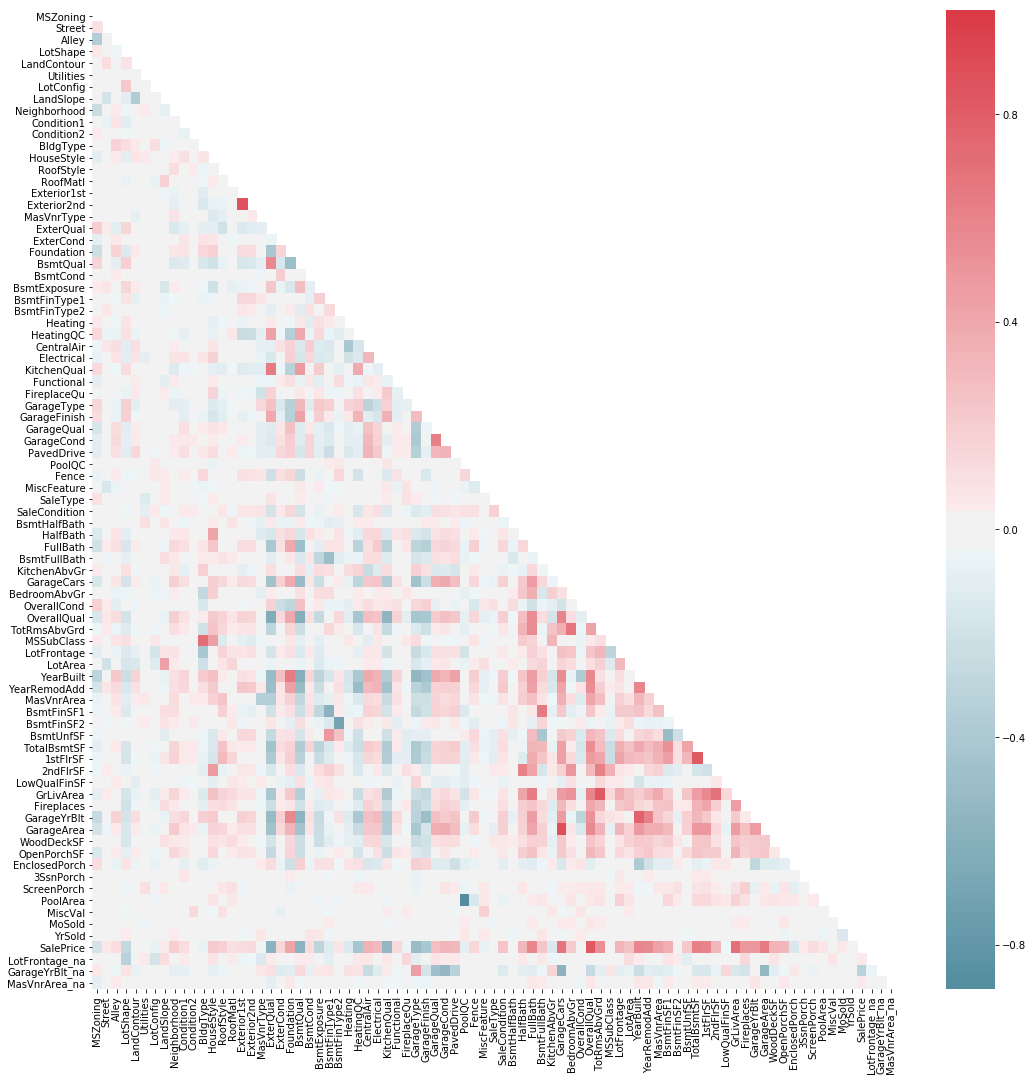

In [444]:
corr=df_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.subplots(figsize=(18, 18))
sns.heatmap(corr, cmap=cmap, mask=mask, center=0,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

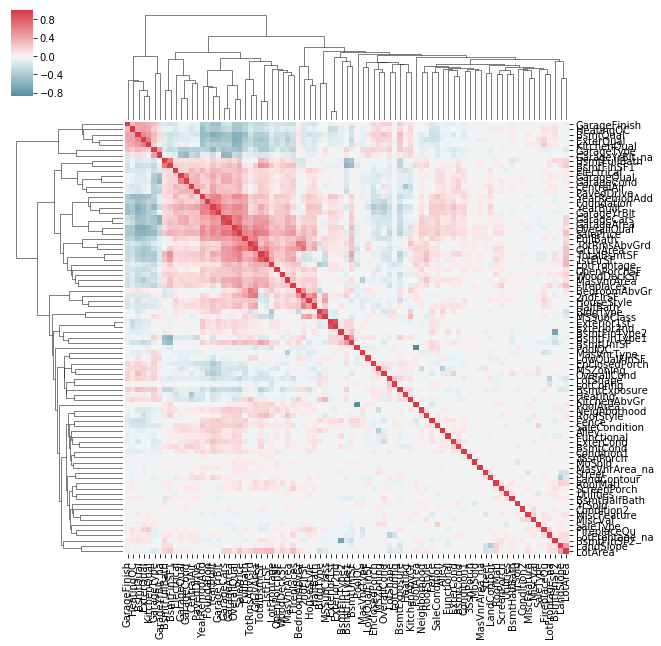

In [448]:
sns.clustermap(corr, cmap=cmap, center=0,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

(29, 29)